In [1]:
%matplotlib inline
import torchvision.models as models
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

print(torch.__version__)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


1.0.1.post2


### Load CIFAR10 & MNIST

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./cifar-data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar-data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


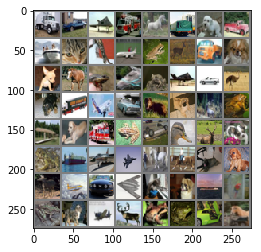

truck


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

#### Plotting utils

In [4]:
# def plot_all(log_every, train_loss, val_loss):
    

def plot_train(log_every, train_loss, val_loss):
    clear_output(wait=False)
    plt.gcf().clear()
    iters = np.arange(0,len(train_loss))*log_every
    iters_val = np.arange(0,len(train_loss))*log_every
    train_plot, = plt.plot(iters, train_loss, 'r', label="training")
    val_plot, = plt.plot(iters, val_loss, 'b', label="validation")
    
    plot_learning([train_plot, val_plot], "Loss")
    plt.title("Cross entropy loss")

    display(plt.gcf())

### Initial Baseline Model Training

1. ResNet18 (PyTorch Implementation)
2. ResNet18 (Raw implementation with hooks for pruning)
3. ResNet34 (PyTorch)
4. ResNet34 (Raw w/ pruning hooks)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.upper = BaseBottleneck(in_planes, planes, stride=stride)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.upper(x)
#         print(out.shape)
        id_x = self.shortcut(x)
#         print(id_x.shape)
        out += id_x
        out = F.relu(out)
        return out
    
    def pass_through_grad(self, module, grad_in, grad_out):
        return grad_in

    def register_hooks_only_shortcut(self):
        self.upper_handle = self.upper.register_backward_hook(self.pass_through_grad)
    
    def register_hooks_only_block(self):
        self.shortcut_handle = self.shortcut.register_backward_hook(self.pass_through_grad)
        
    def unregister_hooks_only_shortcut(self):
        self.upper_handle.remove()
        
    def unregister_hooks_only_block(self):
        self.shortcut_handle.remove()
    
    
class BaseBottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, in_planes, planes, stride=1):
        super(BaseBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        return out
    
    
class Base(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(Base, self).__init__()
        self.l1 = nn.Sequential(
            nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes)
        )
        self.l2 = nn.Sequential(
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(planes)
        )    
            
    def forward(self, x):
        out = F.relu(self.l1(x))
        out = self.l2(out)
        return out
    

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.upper = Base(in_planes, planes, stride=stride)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
            
    def pass_through_grad(self, module, grad_in, grad_out):
        return grad_in

    def forward(self, x):
        out = self.upper(x)
        id_x = self.shortcut(x)
        out += id_x
        out = F.relu(out)
        return out
    
    def register_hooks_only_shortcut(self):
        self.upper_handle = self.upper.register_backward_hook(self.pass_through_grad)
    
    def register_hooks_only_block(self):
        self.shortcut_handle = self.shortcut.register_backward_hook(self.pass_through_grad)
        
    def unregister_hooks_only_shortcut(self):
        self.upper_handle.remove()
        
    def unregister_hooks_only_block(self):
        self.shortcut_handle.remove()


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.blocks = []
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        
        # Storage variables for various hooks measuring gradient magnitude
        self.input_grad_magnitude = []
        self.hook_dict = dict({})
        
        # Create path length dict
        self.path_length = 1
        self.path_length_magnitudes = dict({})
        for i in range(0,np.sum(num_blocks)+1):
            self.path_length_magnitudes[i] = []

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        layer = nn.Sequential(*layers)
        self.blocks.extend(layers)
#         layer.register_backward_hook(back_hook)
        return layer

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def set_path_length(self, i):
        self.path_length = i
    
    def measure_input_grad(self, module, grad_in, grad_out):
        m = torch.norm(grad_out[0], p=2).item()
        self.path_length_magnitudes[self.path_length].append(m)
        print(m)
        
    def register_path_length_hooks(self):
        # Sample a self.path_length number of blocks
        indices = list(range(len(net.blocks)))
        selected_indices = np.random.choice(indices, size=(self.path_length), replace=False)
        unselected_indices = list(set(indices) - set(selected_indices))
        unselected_blocks = []
        for idx in unselected_indices:
            unselected_blocks.append(net.blocks[idx])

        selected_blocks = []
        for idx in selected_indices:
            selected_blocks.append(net.blocks[idx])
            
        self.selected_blocks = selected_blocks
        self.unselected_blocks = unselected_blocks
        
        for _block in self.selected_blocks:
            _block.register_hooks_only_block()
        for _block in self.unselected_blocks:
            _block.register_hooks_only_shortcut()
            
    def unregister_path_length_hooks(self):
        for _block in self.selected_blocks:
            _block.unregister_hooks_only_block()
        for _block in self.unselected_blocks:
            _block.unregister_hooks_only_shortcut()
        
    
    def register_hooks(self):
        input_grad_handle = self.conv1.register_backward_hook(self.measure_input_grad)
        self.hook_dict['input_grad'] = input_grad_handle
        self.register_path_length_hooks()
        
    def unregister_hooks(self):
        input_grad_handle = self.hook_dict['input_grad']
        input_grad_handle.remove()
        del self.hook_dict['input_grad']
        self.unregister_path_length_hooks()


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


def test():
    net = ResNet18()
    y = net(torch.randn(1,3,32,32))
    print(y.size())

In [7]:
# %%capture
# from resnet import ResNet18
net = ResNet18()
net = net.to(device)

### Instantiate Optimizer

In [51]:
import torch.optim as optim
# from torch.autograd import Variable

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)

### Define hooks

In [52]:
def measure_input_grad2(module, grad_in, grad_out):
    print('Norm of gradient arriving at input')
    print(torch.norm(grad_out[0], p=2).item())

### Train Model

In [54]:
running_loss = 0.0
train_loss = []
val_loss = []
PRINT = 10
MEASURE_GRAD = 10
N_EPOCH = 1

for epoch in range(N_EPOCH):  # loop over the dataset multiple times
    print('Starting epoch {}'.format(epoch))
    for i, data in enumerate(trainloader, 0):
        if i == 30:
            break
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Attach hooks to measure magnitude of input grad through a "characteristic path"
        if (i+1) % MEASURE_GRAD == 0:
#             pl = np.random.randint(17)
            pl = 1
            net.set_path_length(pl)
            net.register_hooks()
            
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Detach hooks for all layers
        if (i+1) % MEASURE_GRAD == 0:
            net.unregister_hooks()

        # print statistics
        running_loss += loss.item()
        if (i+1) % PRINT == 0:    # print every PRINT mini-batches
            train_loss.append(running_loss/PRINT)
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / PRINT))

            
            # Compute validation accuracy
#             net.eval()
#             with torch.no_grad():
# #                 for test_idx, (test_inputs, test_labels) in enumerate(testloader, 0):
#                 test_idx, (test_inputs, test_labels) = next(enumerate(testloader, 0))
#                 test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
#                 test_outputs = net(test_inputs)
#                 test_loss = criterion(test_outputs, test_labels)
#                 val_loss.append(test_loss)
# #                 plot(PRINT, train_loss, val_loss)
#             net.train()
            running_loss = 0.0
        
        
#         hl, = plt.plot([], [])

# def update_line(hl, new_data):
#     hl.set_xdata(numpy.append(hl.get_xdata(), new_data))
#     hl.set_ydata(numpy.append(hl.get_ydata(), new_data))
#     plt.draw()

print('Finished Training')

Starting epoch 0
0.100275419652462
[1,    10] loss: 1.740
0.08635467290878296
[1,    20] loss: 1.718
0.08942247927188873
[1,    30] loss: 1.765
Finished Training


In [57]:
net.path_length_magnitudes[net.path_length]

[0.060540422797203064,
 0.08065752685070038,
 0.0826827883720398,
 0.06743600219488144,
 0.100275419652462,
 0.08635467290878296,
 0.08942247927188873]

TODO: Before re-running, rename variable to `x_vals2/y_vals2` so path length 1 info not lost

In [60]:
x_vals_4 = []
y_vals_4 = []
for length, mags in magnitudes_4.items():
    for m in mags:
        x_vals_4.append(length)
        y_vals_4.append(m)

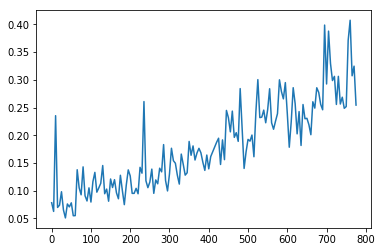

In [61]:
plt.plot(np.arange(0,len(y_vals_4))*5, y_vals_4)

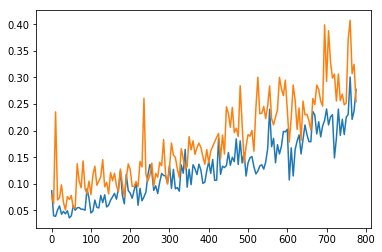

In [69]:
plt.plot(np.arange(0,len(y_vals))*5, np.array(y_vals))
plt.plot(np.arange(0,len(y_vals_2))*5, y_vals_2)
plt.plot(np.arange(0,len(y_vals_3))*5, y_vals_3)
plt.plot(np.arange(0,len(y_vals_4))*5, y_vals_4)

In [73]:
values = pd.DataFrame({'1': y_vals, '15': y_vals_2, '16': y_vals_3, '0': y_vals_4})

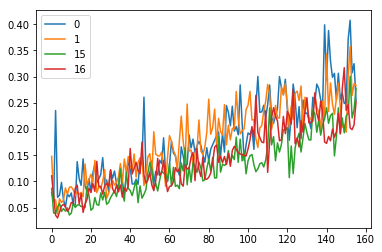

In [74]:
values.plot()

In [ ]:
values